In [1]:
import SiemensQuadraProperties as sqp
from ActivityTools import *
from SimulationDataset import *

import multiprocessing as mp
mp.set_start_method('fork')

from multiprocessing import Pool
import random
import numpy as np
import matplotlib.pyplot as mpl
# myColours=[royalblue, darkorange, yellowgreen, hotpink, orangered]
myColours = []
for colour in mpl.cm.viridis( np.linspace( 0.05, 0.8, 4 ) ):
    myColours.append( colour )
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=myColours)

params = {'legend.fontsize': 15,
          'legend.title_fontsize': 15,
          'legend.loc': "lower right",
          'axes.labelsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15}
mpl.rcParams.update(params)

The NEMU NU 2-2012 calculation for variation of NECR with source activity, although now we are only interested in the maximum value

In [2]:
def NECRatTimeF18( tracerData, crystalData, crystalActivity, detectorRadius, phantomLength, detectorMaterial, simulationWindow=1E-3, coincidenceWindow=4.7E-9 ):
    # NEMU NU 2-2012 says 650mm window for 700mm phantom, so keep the same relation
    zWindow = (phantomLength - 50) / 2

    # get volume in cc
    phantomRadius = 20.3 / 2.0
    phantomVolume = phantomRadius * phantomRadius * math.pi * phantomLength / 10.0 # assume length in mm

    necrAtTime = []
    trueAtTime = []
    rPlusSAtTime = []
    activityAtTime = []
    for time in range( 0, 700, 20 ):
        timeSec = float(time) * 60.0
        activity = F18ActivityAtTime( 1100E6, timeSec )

        activityList = []
        dataList = []
        # Hanna: Add crystalActivity to the activityList only if the crystal material is radioactive
        if detectorMaterial == "LSO" or detectorMaterial == "LYSO" :
            activityList = [activity, crystalActivity]
            dataList = [tracerData, crystalData]
        else :
            activityList = [activity]
            dataList = [tracerData]
        necr, true, rPlusS, scatters, randoms = DetectedCoincidences( activityList, dataList, simulationWindow, coincidenceWindow, detectorRadius, ZMin=-zWindow, ZMax=zWindow )
        necrAtTime.append( necr )
        trueAtTime.append( true )
        rPlusSAtTime.append( rPlusS )
        activityAtTime.append( activity / phantomVolume )

    mpl.clf()
    return activityAtTime, necrAtTime, trueAtTime, rPlusSAtTime

WARNING: this calculation will take a long time

We choose a range of test detector lengths (the real lengths are calculated using discrete detector component sizes) and for each one find the peak NECR value with a given source. We then repeat for a range of different source lengths. This requires a large amount of simulation and calculation of the decay coincidences.

Both the simulation window size and the dataset size will have a significant impact on the total calculation time. Existing datasets will be re-used automatically (mitigating this issue somewhat) and the simulation window has the greatest effect on statistical fluctuation in the result (10ms window recommended, but this will be slow)

Although the simulation and the coincidence calculation are single-threaded, they can be run completely in parallel. A simple multiprocessing model gives close to ideal scaling - 10 processes are used by default, but adjust this to suit your system

In [3]:
# Investigate ideal detector length with Siemens geometry
def OneDetector( detectorLength, phantomLength, detectorMaterial, simulationWindow=1E-3, coincidenceWindow=4.7E-9 ):
    # Fix random seed for reproducibility, don't if you want variation
    # Has to be set in this method, not before, because this is where we enter the worker processes
    random.seed( detectorLength )
    tracerData = CreateDataset( detectorLength, "Siemens", phantomLength, "LinearF18", 1000000, 435.0, 585.0, detectorMaterial )
    crystalData = None
    crystalActivity = None
    #calculate crystal activity and create crystalDataset only if the crystal is radioactive
    if detectorMaterial == "LSO" or detectorMaterial == "LYSO" :
        crystalActivity= sqp.Lu176decaysInMass( sqp.DetectorMassLength( detectorLength, detectorMaterial ) )
        crystalData = CreateDataset( detectorLength, "Siemens", phantomLength, "Siemens", 1000000, 435.0, 585.0, detectorMaterial )

    activityAtTimeSiemens, necrAtTimeSiemens, trueAtTimeSiemens, rPlusSAtTimeSiemens = NECRatTimeF18( tracerData, crystalData, crystalActivity, sqp.DetectorRadius(), phantomLength, detectorMaterial, simulationWindow, coincidenceWindow )
    return ( max( necrAtTimeSiemens ), sqp.DetectorDiscreteLength( detectorLength ) )

def PeakNECRWithLengthMultiprocess( phantomLength, detectorMaterial, simulationWindow=1E-3, coincidenceWindow=4.7E-9, processes=5 ):
    # Create the arguments for each process
    detectorLengths = [ 100, 300, 500, 700, 900, 1100, 1300, 1500, 1700, 1900 ]
    arguments = []
    realLengths = []
    maxNECR = []
    for detectorLength in detectorLengths:
        arguments.append( ( detectorLength, phantomLength, detectorMaterial, simulationWindow, coincidenceWindow ) )
        # result = OneDetector(detectorLength, phantomLength, detectorMaterial, simulationWindow, coincidenceWindow)
        # maxNECR.append(result[0])
        # realLengths.append(result[1])
    # Launch a separate process for each detector length
    result = None
    with Pool( processes=processes ) as p:
        result = p.starmap( OneDetector, arguments )

    # Unpack the results
    realLengths = []
    maxNECR = []
    for entry in result:
        maxNECR.append( entry[0] )
        realLengths.append( entry[1] )
    return realLengths, maxNECR

detectorLengths = []
maxNECRlines = []
trialPhantoms = [ 300, 700, 1100, 1500 ]
detectorMaterial = "BGO"
for phantomLength in trialPhantoms:
    detectorLengths, maxNECR = PeakNECRWithLengthMultiprocess( phantomLength, detectorMaterial, simulationWindow=1E-3, coincidenceWindow=4.7E-9 )
    maxNECRlines.append( maxNECR )

DetectorMaterial in createdataset: DetectorMaterial in createdataset: DetectorMaterial in createdataset: DetectorMaterial in createdataset: DetectorMaterial in createdataset:      BGOBGOBGOBGOBGO




Running command = Running command = Running command = Running command = Running command =      ../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 900 --source LinearF18 --phantomLengthMM 300 --outputFileName hits.n1000000.SiemensBlock.900mm.LinearF18.300mm.1234.csv --randomSeed 1234 --detectorMaterial BGO../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 100 --source LinearF18 --phantomLengthMM 300 --outputFileName hits.n1000000.SiemensBlock.100mm.LinearF18.300mm.1234.csv --randomSeed 1234 --detectorMaterial BGO../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 500 --source LinearF18 --phantomLengthMM 300 --outputFileName hits.n1000000.SiemensBlock.500mm.LinearF18.300mm.1234.csv --randomSeed 1234 --detec

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.
ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.
ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.
ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.
ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron 

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron 

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron 

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron 

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

DetectorMaterial in createdataset:  BGO
Running command =  ../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 1900 --source LinearF18 --phantomLengthMM 300 --outputFileName hits.n1000000.SiemensBlock.1900mm.LinearF18.300mm.1234.csv --randomSeed 1234 --detectorMaterial BGO

**************************************************************
 Geant4 version Name: geant4-10-06-patch-02    (29-May-2020)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Reference Physics List QBBC 
Checking overlaps for volume Phantom (G4Tubs) ... OK! 
Selected detector material: G4_BGO
Siemens Quadra detector variant with nRings: 60
Checking overlaps for volume Envelope (G4Tu

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron 

Running command = Running command = Running command = Running command = Running command =      ../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 900 --source LinearF18 --phantomLengthMM 700 --outputFileName hits.n1000000.SiemensBlock.900mm.LinearF18.700mm.1234.csv --randomSeed 1234 --detectorMaterial BGO../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 100 --source LinearF18 --phantomLengthMM 700 --outputFileName hits.n1000000.SiemensBlock.100mm.LinearF18.700mm.1234.csv --randomSeed 1234 --detectorMaterial BGO../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 500 --source LinearF18 --phantomLengthMM 700 --outputFileName hits.n1000000.SiemensBlock.500mm.LinearF18.700mm.1234.csv --randomSeed 1234 --detectorMaterial BGO../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 700 --source LinearF18 --phantomLengthMM 700 --outputFileName hits.n1000000.SiemensBlock.700mm.LinearF18.

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.
ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.
ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.
ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.
ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
70388.0 events loaded (1000000 simulated) with average 1.0200318236062966 hits/event
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag     

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.


165269.0 events loaded (1000000 simulated) with average 1.0535974683697487 hits/event

phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      Lamb

Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron 

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron 

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron 

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

DetectorMaterial in createdataset:  BGO
Running command =  ../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 1900 --source LinearF18 --phantomLengthMM 700 --outputFileName hits.n1000000.SiemensBlock.1900mm.LinearF18.700mm.1234.csv --randomSeed 1234 --detectorMaterial BGO

**************************************************************
 Geant4 version Name: geant4-10-06-patch-02    (29-May-2020)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Reference Physics List QBBC 
Checking overlaps for volume Phantom (G4Tubs) ... OK! 
Selected detector material: G4_BGO
Siemens Quadra detector variant with nRings: 60
Checking overlaps for volume Envelope (G4Tu

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron 

../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 700 --source LinearF18 --phantomLengthMM 1100 --outputFileName hits.n1000000.SiemensBlock.700mm.LinearF18.1100mm.1234.csv --randomSeed 1234 --detectorMaterial BGO../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 500 --source LinearF18 --phantomLengthMM 1100 --outputFileName hits.n1000000.SiemensBlock.500mm.LinearF18.1100mm.1234.csv --randomSeed 1234 --detectorMaterial BGO../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 100 --source LinearF18 --phantomLengthMM 1100 --outputFileName hits.n1000000.SiemensBlock.100mm.LinearF18.1100mm.1234.csv --randomSeed 1234 --detectorMaterial BGO../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 900 --source LinearF18 --phantomLengthMM 1100 --outputFileName hits.n1000000.SiemensBlock.900mm.LinearF18.1100mm.1234.csv --randomSeed 1234 --detectorMaterial BGO




***************************

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.
ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.
ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.
ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.
ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
54576.0 events loaded (1000000 simulated) with average 1.0169671650542362 hits/event
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag     

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron 

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron 

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron 

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

DetectorMaterial in createdataset:  BGO
Running command =  ../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 1900 --source LinearF18 --phantomLengthMM 1100 --outputFileName hits.n1000000.SiemensBlock.1900mm.LinearF18.1100mm.1234.csv --randomSeed 1234 --detectorMaterial BGO

**************************************************************
 Geant4 version Name: geant4-10-06-patch-02    (29-May-2020)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Reference Physics List QBBC 
Checking overlaps for volume Phantom (G4Tubs) ... OK! 
Selected detector material: G4_BGO
Siemens Quadra detector variant with nRings: 60
Checking overlaps for volume Envelope (G4

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron 

Running command = Running command = Running command = Running command = Running command =      ../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 700 --source LinearF18 --phantomLengthMM 1500 --outputFileName hits.n1000000.SiemensBlock.700mm.LinearF18.1500mm.1234.csv --randomSeed 1234 --detectorMaterial BGO../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 500 --source LinearF18 --phantomLengthMM 1500 --outputFileName hits.n1000000.SiemensBlock.500mm.LinearF18.1500mm.1234.csv --randomSeed 1234 --detectorMaterial BGO../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 300 --source LinearF18 --phantomLengthMM 1500 --outputFileName hits.n1000000.SiemensBlock.300mm.LinearF18.1500mm.1234.csv --randomSeed 1234 --detectorMaterial BGO../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 900 --source LinearF18 --phantomLengthMM 1500 --outputFileName hits.n1000000.SiemensBlock.900mm.Lin

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.
ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.
ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.
ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.
ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  Defau

Simulation complete
42344.0 events loaded (1000000 simulated) with average 1.0160825618741733 hits/event
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag     

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron 

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron 

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron 

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

DetectorMaterial in createdataset:  BGO
Running command =  ../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 1900 --source LinearF18 --phantomLengthMM 1500 --outputFileName hits.n1000000.SiemensBlock.1900mm.LinearF18.1500mm.1234.csv --randomSeed 1234 --detectorMaterial BGO

**************************************************************
 Geant4 version Name: geant4-10-06-patch-02    (29-May-2020)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Reference Physics List QBBC 
Checking overlaps for volume Phantom (G4Tubs) ... OK! 
Selected detector material: G4_BGO
Siemens Quadra detector variant with nRings: 60
Checking overlaps for volume Envelope (G4

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron 

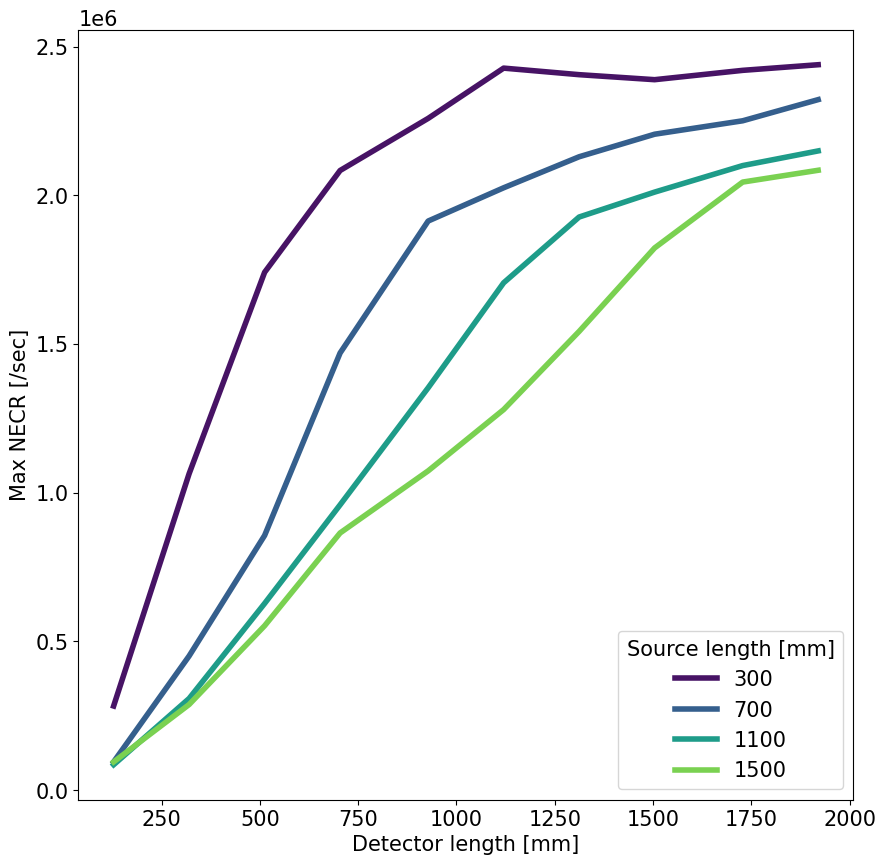

In [4]:
for i, phantomLength in enumerate( trialPhantoms ):
    mpl.plot( detectorLengths, maxNECRlines[i], label=phantomLength, linewidth=4.0 )

mpl.xlabel( "Detector length [mm]" )
mpl.ylabel( "Max NECR [/sec]" )
mpl.legend( trialPhantoms, title="Source length [mm]" )
mpl.gcf().set_size_inches( 10, 10 )
mpl.show()

Illustrate the scaling of NECR up to the source length, and beyond

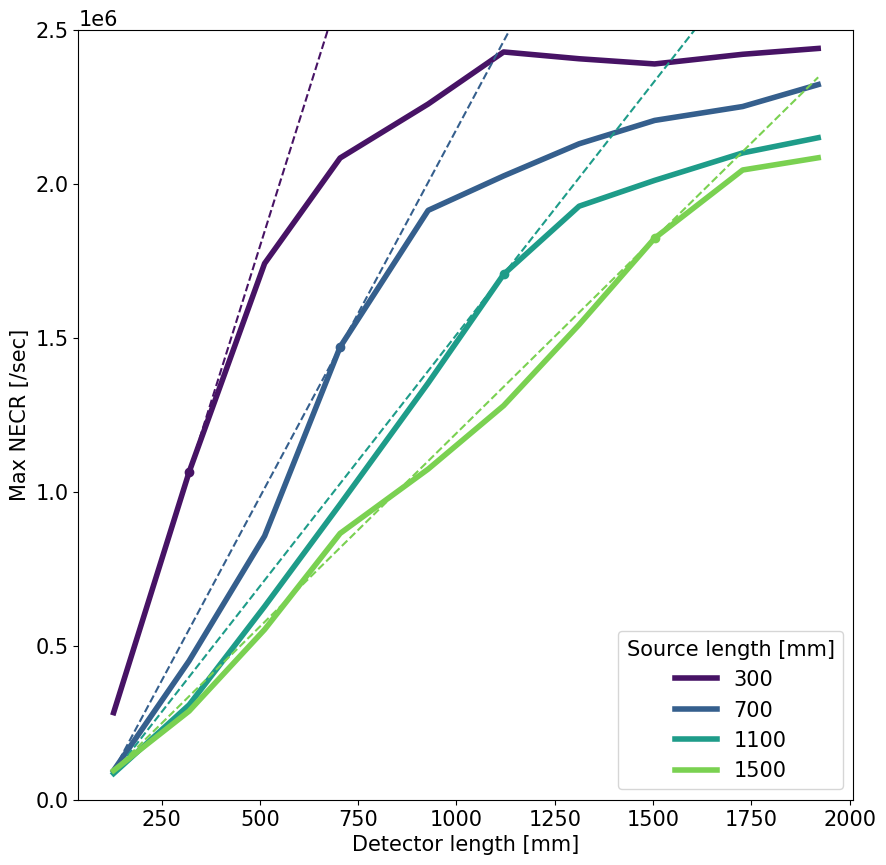

In [5]:
def scale( y0, y1, x1 ):
    m = (y1 - y0) / (x1 - detectorLengths[0])
    y2 = m * ( detectorLengths[-1] - x1 )
    y2 += y1
    return [ y0, y2 ]

def plotThreeParts( xs, ys, i, label, colour ):
    theplot, = mpl.plot( xs, ys, label=label, color=colour, linewidth=4.0 )
    mpl.plot( [xs[0], xs[-1]], scale(ys[0], ys[i], xs[i]), label="_", color=colour, linestyle="dashed" )
    mpl.scatter( [xs[i]], [ys[i]], label="_", color=colour )
    return theplot

legendEntries = []
for i, trialPhantom in enumerate( trialPhantoms ):

    # find the detector length index closest to the source length
    detectorLengthIndex = 0
    while detectorLengths[ detectorLengthIndex ] < trialPhantom:
        detectorLengthIndex += 1

    theplot = plotThreeParts( detectorLengths, maxNECRlines[i], detectorLengthIndex, trialPhantoms[i], myColours[i] )
    legendEntries.append( theplot )

mpl.xlabel( "Detector length [mm]")
mpl.ylabel( "Max NECR [/sec]")
mpl.legend( legendEntries, trialPhantoms, title="Source length [mm]" )
mpl.gcf().set_size_inches(10,10)
mpl.ylim( [0.0, 2.5e6] )
mpl.show()